This notebook checks if we are spinning off from a base experiment which has been run for 100 years.

In [1]:
import cartopy.crs as ccrs
import cosima_cookbook as cc
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean as cm
from dask.distributed import Client
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

# Avoid the Runtime errors in true_divide encountered when trying to divide by zero
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)
warnings.filterwarnings('ignore', category = ResourceWarning)
warnings.filterwarnings('ignore', category = BytesWarning)

# matplotlib stuff:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib
from mpl_toolkits.mplot3d import axes3d
%matplotlib inline
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['lines.linewidth'] = 2.0

In [2]:
import logging
logger = logging.getLogger("distributed.utils_perf")
logger.setLevel(logging.ERROR)

In [3]:
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/43627/status,
Dashboard: /proxy/43627/status,Workers: 4
Total threads: 16,Total memory: 64.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42365,Workers: 4
Dashboard: /proxy/43627/status,Total threads: 16
Started: Just now,Total memory: 64.00 GiB
Comm: tcp://127.0.0.1:38349,Total threads: 4
Dashboard: /proxy/33471/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:41945,


In [4]:
db = '/g/data/x77/db6174/access-om2/archive/databases/cc_database_nostress_paramKPP.db'
session_cont = cc.database.create_session(db)

db = '/scratch/x77/db6174/access-om2/archive/databases/cc_database_param_kpp_extended2.db'
session_ffa1 = cc.database.create_session(db)

expt = ['025deg_jra55_ryf_param_kpp3', '025deg_jra55_ryf_param_kpp_extended2']
session = [session_cont, session_ffa1]
name = ['Control', 'Flux-forced']

## Temperature field

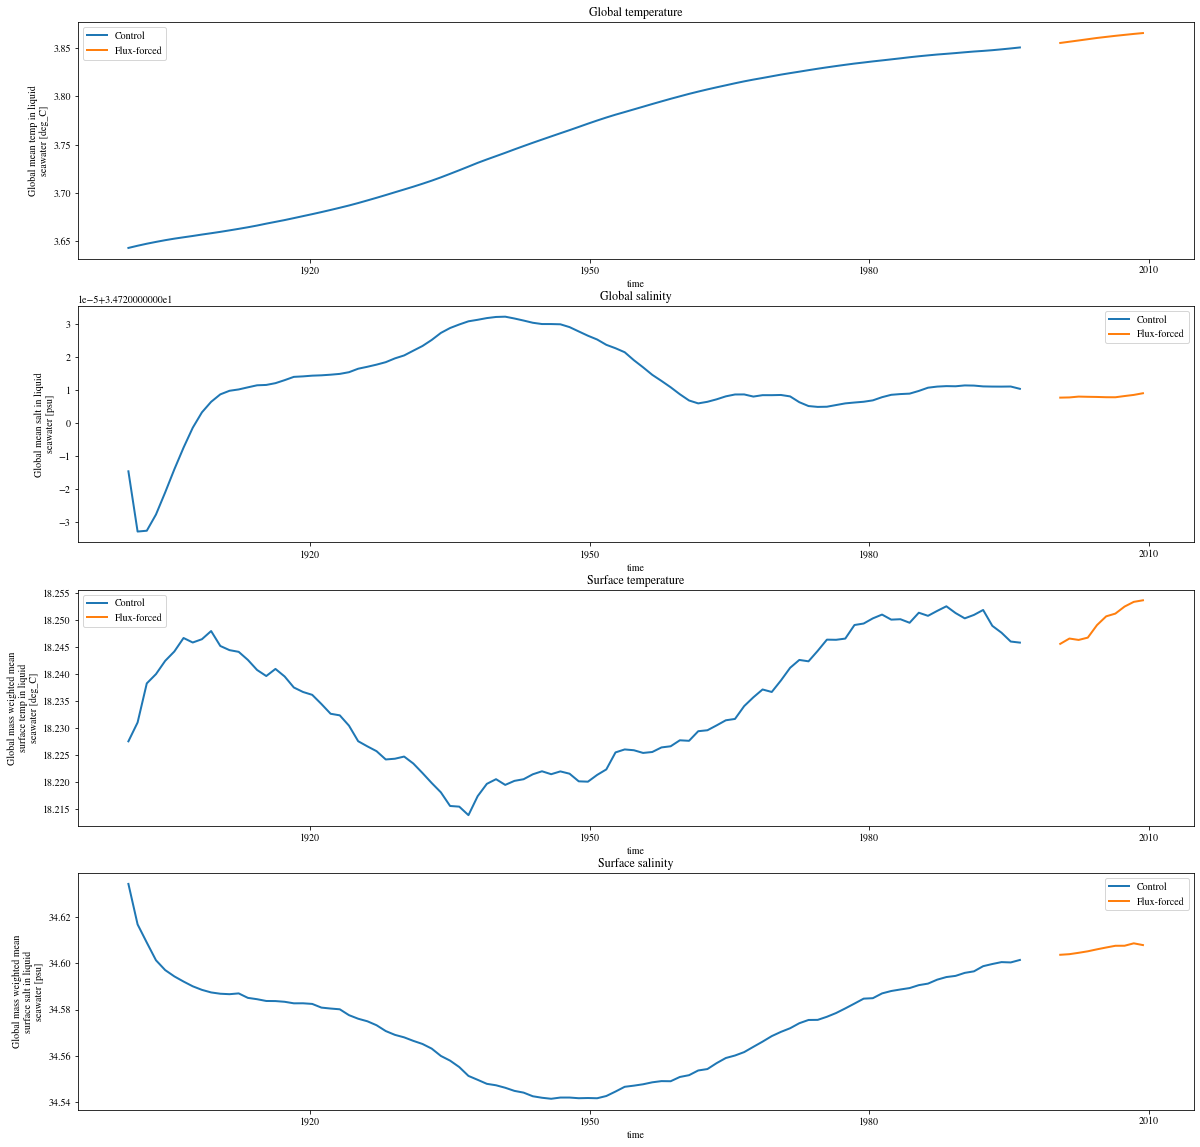

In [8]:
ncoarse = 12

fig, axes = plt.subplots(nrows = 4, figsize = (20, 20))

var_list = ['temp_global_ave',    'salt_global_ave', 'temp_surface_ave',    'salt_surface_ave']
var_name = ['Global temperature', 'Global salinity', 'Surface temperature', 'Surface salinity']
for i, j in enumerate(expt):
    for k, l in enumerate(var_list):
        if(i == 0):
            variable = cc.querying.getvar(expt = expt[i], session = session[i], variable = l, start_time = '1900-01-01', end_time = '1997-12-31').sel(time = slice('1900-01-01', '1997-12-31'))
        else:
            variable = cc.querying.getvar(expt = expt[i], session = session[i], variable = l, start_time = '2000-01-01', end_time = '2009-12-31').sel(time = slice('2000-01-01', '2009-12-31'))
        variable = variable.coarsen({"time": ncoarse*30}, boundary = "trim").mean()
        variable.plot(ax = axes[k], label = name[i])
        axes[k].legend()
        axes[k].set_title(var_name[k])

Text(0.5, 1.0, 'Drake Passage Transport')

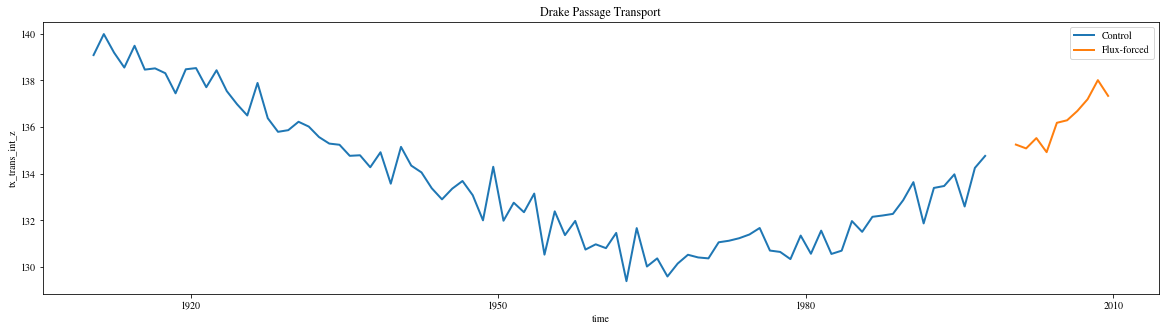

In [9]:
xmin = -69.9
ymin = -71.6
ymax = -51.0
rho0 = 1036

ncoarse = 12

plt.figure(figsize = (20,5))

for i, j in enumerate(session):
    if(i == 0):
        DP_trans = cc.querying.getvar(expt[i], 'tx_trans_int_z', session = j, start_time = '1911-01-01', end_time = '1997-12-31').sel(
            xu_ocean = xmin, method='nearest').sel(yt_ocean = slice(ymin, ymax)).sum('yt_ocean')/rho0/1e6
    else:
        DP_trans = cc.querying.getvar(expt[i], 'tx_trans_int_z', session = j, start_time = '2000-01-01', end_time = '2009-12-31').sel(
            xu_ocean = xmin, method='nearest').sel(yt_ocean = slice(ymin, ymax)).sum('yt_ocean')/rho0/1e6
    DP_trans = DP_trans.coarsen({"time": ncoarse}, boundary = "trim").mean()
    DP_trans.plot(label = name[i])
    plt.legend()

plt.title('Drake Passage Transport')

## AMOC

Text(0.5, 1.0, 'AMOC cell')

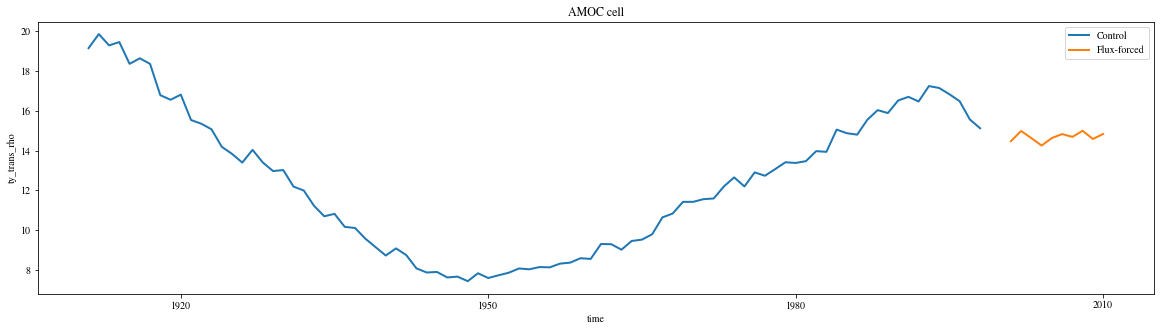

In [10]:
plt.figure(figsize = (20,5))

for i, j in enumerate(session):
    if(i == 0):
        psi_amoc = cc.querying.getvar(expt[i], 'ty_trans_rho', session = j, start_time = '1911-01-01', end_time = '1997-12-31').sel(
            grid_xt_ocean = slice(-103, -5)).sum('grid_xt_ocean').sel(method = 'Nearest', grid_yu_ocean = 26)*1.0e-9
    else:
        psi_amoc = cc.querying.getvar(expt[i], 'ty_trans_rho', session = j, start_time = '2000-01-01', end_time = '2009-12-31').sel(
            grid_xt_ocean = slice(-103, -5)).sum('grid_xt_ocean').sel(method = 'Nearest', grid_yu_ocean = 26)*1.0e-9
    psi_amoc_sum = psi_amoc.cumsum('potrho') - psi_amoc.sum('potrho')
    psi_amoc_sum = psi_amoc_sum.sel(potrho = slice(1035.5, None)).max('potrho').resample(time = 'Y').mean()
    psi_amoc_sum.plot(label = name[i])
    plt.legend()

plt.title('AMOC cell')